In [123]:
import numpy as np
import matplotlib.pyplot as plt
import quadrotor

In [124]:
dt = quadrotor.DELTA_T
m = quadrotor.MASS
g = quadrotor.GRAVITY
r_l = quadrotor.LENGTH
I = quadrotor.INERTIA


def get_linearization(z,u):
  x = z[0]
  vx = z[1]
  y = z[2]
  vy = z[3]
  theta = z[4]
  omega = z[5]

  u1 = u[0]
  u2 = u[1]

  dfdx = np.array([[1,dt,0,0,0,0], [0,1,0,0,-(dt*(u1+u2)*np.cos(theta))/m,0], [0,0,1,dt,0,0],
                   [0,0,0,1,-(dt*(u1+u2)*np.sin(theta))/m,0], [0,0,0,0,1,dt], [0,0,0,0,0,1]])
  
  dfdu = np.array([[0,0], [(-dt*np.sin(theta))/m, (-dt*np.sin(theta))/m], [0,0],
                   [(dt*np.cos(theta))/m, (dt*np.cos(theta))/m], [0,0], [(dt*r_l/I), -(dt*r_l/I)]])
  
  A = dfdx
  B = dfdu

  return A,B

In [128]:
#state equations for trajectory
#writing xbar to solve the problem
#initial position
r = 1
alpha = 0
ulfa = 0
xbar = np.array([[r*np.cos(alpha)],[-r*np.sin(alpha)*(np.pi)/(500)],[r*np.sin(alpha)],[r*np.cos(alpha)*(np.pi)/(500)],[ulfa],[0]])
ubar = np.array([[(m*g - (m*r*np.sin(alpha)*((np.pi)/500)*((np.pi)/500)))/2], [(m*g - (m*r*np.sin(alpha)*((np.pi)/500)*((np.pi)/500)))/2]])
#ubar = np.array([[m*np.cos(alpha)*(np.pi*np.pi)/(500*500*np.sqrt(2))], [m*np.cos(alpha)*(np.pi*np.pi)/(500*500*np.sqrt(2))]])
#ubar = np.array([[m*g/2], [m*g/2]])

#Circle equation
for i in range(1000):

  if i==999:
    alpha = alpha+ (np.pi)/(500)
    bar = np.array([[r*np.cos(alpha)],[-r*np.sin(alpha)*(np.pi)/(500)],[r*np.sin(alpha)],[r*np.cos(alpha)*(np.pi)/(500)],[ulfa],[0]])
    xbar = np.hstack((xbar,bar))
  else:
    alpha = alpha+ (np.pi)/(500)
    bar = np.array([[r*np.cos(alpha)],[-r*np.sin(alpha)*(np.pi)/(500)],[r*np.sin(alpha)],[r*np.cos(alpha)*(np.pi)/(500)],[ulfa],[0]])
    xbar = np.hstack((xbar,bar))
    baru = np.array([[(m*g - (m*r*np.sin(alpha)*((np.pi)/500)*((np.pi)/500)))/2], [(m*g - (m*r*np.sin(alpha)*((np.pi)/500)*((np.pi)/500)))/2]])
    #baru = np.array([[m*np.cos(alpha)*(np.pi*np.pi)/(500*500*np.sqrt(2))], [m*np.cos(alpha)*(np.pi*np.pi)/(500*500*np.sqrt(2))]])
    ubar = np.hstack((ubar,baru))
#Creating cost functions
cost_Q = 100
cost_Q2 = 1
cost_R = 0.1
Q = np.array([[cost_Q,0,0,0,0,0],[0,cost_Q2,0,0,0,0],[0,0,cost_Q,0,0,0],[0,0,0,cost_Q2,0,0],[0,0,0,0,cost_Q,0],[0,0,0,0,0,cost_Q2]])
R = np.array([[cost_R,0],[0,cost_R]])

In [129]:
def get_A_B(xstar, ustar):
  A_list = []
  B_list = []
  for i in range(1000):
    A, B = get_linearization(xstar[:,i],ustar[:,i])
    A_list.append(A)
    B_list.append(B)
  return A_list, B_list

In [130]:
def solve_LQR_trajectory(A_list, B_list, Q, R, x_bar, N):
       
        P_1 = Q
        xn_bar = np.zeros((x_bar.shape[0],1))
        xi_bar = x_bar[:,N]
        xi_bar = xi_bar.reshape((x_bar.shape[0],1))
        np.copyto(xn_bar, xi_bar)
        q = -Q@xn_bar
        p_1 = q
        
        K_gains = []
        k_feedforward = []
        
        for i in range(N-1,-1,-1):
            
            #Added these since A and B are not same
            A = A_list[i]
            B = B_list[i]
            B_T = B.transpose()
            A_T = A.transpose()
        

            xn_bar = np.zeros((x_bar.shape[0],1))
            xi_bar = x_bar[:,i]
            xi_bar = xi_bar.reshape((x_bar.shape[0],1))
            np.copyto(xn_bar, xi_bar)
            q = -Q@xn_bar
            
            term = R + B_T@P_1@B
            inv_term = np.linalg.inv(term)

            Kn = -inv_term@B_T@P_1@A
            K_gains.insert(0,Kn)
            
            P = Q + A_T@P_1@A + A_T@P_1@B@Kn
            kn = -inv_term@B_T@p_1
            temp = kn.reshape((kn.shape[0],))

            k_feedforward.insert(0, temp)
        
            p = q + A_T@p_1 + A_T@P_1@B@kn
            
            P_1 = P
            p_1 = p
        
        return K_gains, k_feedforward

In [131]:
# we can simulate the robot but we need to provide a controller of the following form
#Writing a controller for Part 2

# u_star_1 = (quadrotor.MASS)*(quadrotor.GRAVITY)/2
# ustar_1 = np.array([[u_star_1],[u_star_1]])
A_list, B_list = get_A_B(xbar,ubar)
K_gains, k_feedforward = solve_LQR_trajectory(A_list, B_list, Q, R, xbar, 1000)

def dummy_controller(state, i):

    state = state.reshape((6,1))
    # u_star = (quadrotor.MASS)*(quadrotor.GRAVITY)/2
    # ustar = np.array([[u_star],[u_star]])
    Kn = K_gains[i]
    kn = k_feedforward[i]
    kn = kn.reshape((kn.shape[0],1))
    xibar = xbar[:,i]
    xibar = xibar.reshape((6,1))
    ustar = ubar[:,i]
    ustar = ustar.reshape((2,1))
    un = Kn@(state) + kn + ustar

    un = un.reshape((2,))
    return un


# we can now simulate for a given number of time steps - here we do 10 seconds
horizon_length = 1000
z0 = np.array([[0],[0],[0],[0],[0],[0]])
z0 = z0.reshape((6,))
t, state, u = quadrotor.simulate(z0, dummy_controller, horizon_length, disturbance = True)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABf3W1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA3MZYiE
ABH//veIHzLLafk613IR560urR9Q7kZxXqS9/iAAAAMAAAMAAOSq/2+9Zj+im+AAABXQArISJA0b
M34HfeIBLw2NULVMqhzqmkC+X53Wgy7Lw2o5tSedGqtnOugH52lIi7P24behEG6Rnkk+WdTQf4eW
uPgCxivMZdxHEjn7VJLwZY+eI9HwO3plS7KgxBP2PAIULur9c1ztvyHTsIHpQ7AWk0MUEIPegRQe
mleg2OVFv447q+4/TWiy/+ZSzz1L5zehMVNsU5uy76TKZxI95ywPynYwwhdU/2fM2AnaYgwOfdkf
69A3REFLf6rK5fLs8TBpH4sqRqPKnDcIE+bSBngHwUCUcKJ4CnZV2Fc2GCOX6fHviA6j/zly2rMM
HUeiwnRJv2v0wCxmVpi0bb9R5cpW87efbtbkapNwAAADAACkO+cZ0stP/OH3eYLy91u40xzbOE20
ByD69s9+DABmn3QWsHL0mPtcVAIzZb7Vh3hwyFyO3O8PEAaWQTIy7/JSRilDyCxY9myTS2XjsHRr
cLZDzeBzHsYgZm1qK0pt5fPalV6EqlIAD4Nb74uRzyrU0QQ+shHMVOqZ2a4jMH+iG/s1HNTN7oNG
1fskfeaXj091zsRKRrFeX+LmnSVB8Bv/QuT0PhVVcA6zeJm8ZqTk+eNoBoluOyRQDTqH22p2lm2B
EiVPOIq2j7Om80MSUIMNWy85Z/x0/DM8+SyzzIHnGfUZtCz0v1tbC22hfXthWPL/Dg1sQI1O0KwZ
x4ks5xg5FPlZL6xaPXrga8kOyT+y0z2pbufVVOzx0bPHTkNrWpa7uB+r20fdAFwDc4/AAABglG4U
ngBDmFDzaoEjQpAWC0qsLd9R/wD2AsMuC2Wweiuy0UPQgWSChQzi0gw+Af7sLqDMgs+J6rFyUNUK
2hQID1JwtEYtks42Zq21zJdSJNqnlwNQm4c8MdgYubMn8OW3saynj1hlWZBPNsYfsCvc6j2jv5BP
/vEGcCvOBUDMYLR70ZJVCVWjdURducoaChFHhD4DiKIAgPMOXGwMzPYcNRoQYXmdSDkPbfkQz97t
VF6RHHxPEtL6irg8U9gcWtxTfFqTfyqmMgJQsL0gz0MTu0qO3uFqkuJf7rwnNn7VX1bGuqAyfohj
p4o+mfQ0tP/hznWkv2JW30317GkV/vC3dMo5K6g9rnNL2/ybbUrAY0Lr3MhIAAWQjzzVlf8HG5k9
6F6MbRQC7IcZKaueHzTflP0HamO2NetvEolNubmOAG179fQnvuz4m07foBSQLp7LtRuCIJOheMjX
rn87aWtUaLV2RJuLpnAh4DHnTGsNIAmF5s8A5A9qpNz2YSMIWuxXojWsJyd70YEJn5m0qXGUapbh
NQx//8uD+n8p4Ztic8NLkvO60FZUhoPGMJtQbPbcolFGRNQ7tUIlg0ySKPlVM10uGcsmcFfc61TZ
KQ3lwus+QoM6++wp5cEEgAv5Thofy4EmuRvwe72xDVTj3dJGIH9QUR47BAplYq5gxLOdToXV8a0X
7ZPJzrNOoPFfEJM7Ogu5wAGVnRiwlOska9ElkmTnStopw4d7UZqfuiTKnDgAonfKVmMITamjtO2n
8VgXwgAB0ZA43Dfh/IP1CyiKfh9IiG1CqbUnu1Z6gn8Cw8ajhyRFjm0A5R7bZCT7VqJJdyomAp2V
5BrsIAtkep3m+42jdxYhyqF36HLXLxZPmWZjtU+HUFaAPCcMklMeEpiji2enVquxJjd7grjrInV+
0T25lgBBDKZNjp60WmwRa//G2eFEHGN97PTESV2vw+uNWN8kvSD0pWJ4TifHO8qiXM5D9Kt7dGeM
L8T5AAI/Jym0tXDMkXOWXwuQqZv6onOZ5fmwQKO4X8zaQhJqdpZE4YvGoD9U49QAb1W4JEEH4mFr
Njsve6FaXAVvqQ19ZuiavpkA4gwVAz1EfPOpNE2TbsJZfEXzfoMXHNxAMTwt36Fvl//72Vn1lDwv
5tXebL/qgbyGcjoAr1gFHlMg5fTbzHdtkzaAph3WRw6qTbhtH1yK7/+Oo4bNiY45LNnQsw7uEGle
OG/9xmw4OJxXL3bPVdqB91pK86fIks52pdnyEwNGEaiSEpi06P/pf4yL5UjNNCRgeoRPuRE54dDB
cfLLCnluFWRYBFl0mKBtSaoceFqwoXQD3HdsXKSPL0/OKgerU7FlOAALf+y52JiTf270dNPmDZoA
liuZEUzB2H5nr8oAc5PRc0MJuPncJ8M1ZxeuPBlnmtWS8r/yjeJZP8HZRJaHNZlxX4F8AAJy5KEz
4AkWTwvVuafu/gJF3AeijUZzyEikkhQuj2MbXCJxh8BMXzbgwSdGQ3HrGcNTjKrN7l86ukTkF0jg
8V6vzjDqsSLZWPdUo1LGv6diGYEiaXtogvjrrh4vCE69+bC+14GZkUcNZf2IlbsfLZR7k2w6qfPB
kJsJWBPKm4TOa80fdbP/9YN1Mbu5S3/KqT++lN96HND/2yL0rRb/VrVEndy6gsYTX+CCS+UWLuIR
SM4QU26h3Cd5pTuTn0Qj8lyW3gJgqm0Dnpl10l9PZQgz5a9kAQIDt9LyfY2n1ynIey/KbUd8In9B
YZVvZrQQ5Vqqy4+7F6RXb/ElCtYydNCz4o+kJzy5KvjGgAAvpsjJgmJS+9oV2Rpmqk4Af/VaD/NN
jFY3uxAr75VcL85SCXmqb1pZmls+tzJRU9HSZ7O2AbCAJ0xelVONffA5Dumo5CHtxlw0mEjoQmLg
XoXgvMw5h6R/UvmoF6S/1na7yJ07RS/YskdGqU1L+ViiTYH5RdeK8lCswkPbwTENkDMEmfV8yIXV
q7oCTAN5leBS/F66u//atr+64mel/UnglAv1sUf9Jxb8The6NSehQUOLxvz2YvkFuWdSUgPQ4GEx
Nmh6VDB6gze+Gd0d22h/4

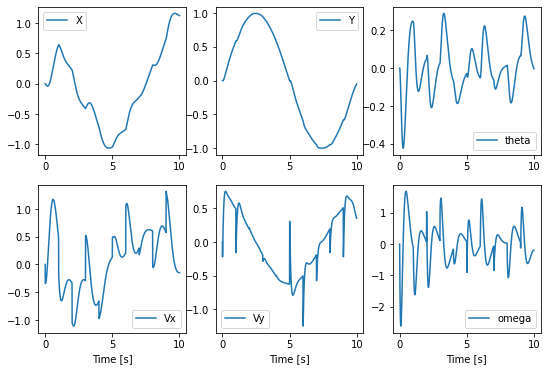

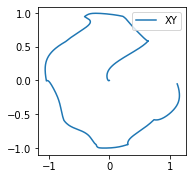

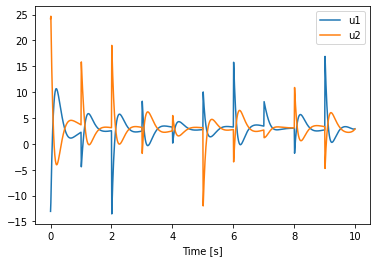

In [132]:
# we can plot the results
#%matplotlib notebook
#%matplotlib inline
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

plt.figure(figsize=[9,6])
plt.subplot(2,3,1)
plt.plot(state[0,:], state[2,:])
plt.legend(['XY'])

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')

# now we can also create an animation
quadrotor.animate_robot(state, u)